### Domain Classification

In [1]:
import torch
from torch import nn
from transformers import AutoModel, AutoTokenizer, AutoConfig
from huggingface_hub import PyTorchModelHubMixin
import json
import pandas as pd
from tqdm import tqdm
import numpy as np

/opt/homebrew/anaconda3/envs/fact/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config):
        super(CustomModel, self).__init__()
        self.model = AutoModel.from_pretrained(config["base_model"])
        self.dropout = nn.Dropout(config["fc_dropout"])
        self.fc = nn.Linear(self.model.config.hidden_size, len(config["id2label"]))

    def forward(self, input_ids, attention_mask):
        features = self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        dropped = self.dropout(features)
        outputs = self.fc(dropped)
        return torch.softmax(outputs[:, 0, :], dim=1)

In [3]:
# Setup configuration and model
# device = "mps"
config = AutoConfig.from_pretrained("nvidia/domain-classifier")
tokenizer = AutoTokenizer.from_pretrained("nvidia/domain-classifier")
model = CustomModel.from_pretrained("nvidia/domain-classifier")
# model.to(device)
model.eval()

CustomModel(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dro

##### Sample Run

In [ ]:
# Prepare and process inputs
text_samples = ["Sports is a popular domain", "Politics is a popular domain"]
inputs = tokenizer(text_samples, return_tensors="pt", 
                   padding="longest", truncation=True)
outputs = model(inputs["input_ids"], inputs["attention_mask"])

In [6]:
# Predict and display results
predicted_classes = torch.argmax(outputs, dim=1)
predicted_domains = [config.id2label[class_idx.item()] for class_idx in predicted_classes.cpu().numpy()]
print(predicted_domains)

['Sports', 'News']


##### Extracting domains

In [4]:
with open("../data/full_data_sampled_gpt2_with_subjects.json", "r") as f:
    dataset = json.load(f)

target_new = [row["target_new"].strip() for row in dataset]

In [5]:
def extract_domains(text_samples, batch_size):   
    outputs = [] 
    # Batch processing
    for i in tqdm(range(0, len(text_samples), batch_size)):
        batch = text_samples[i:i + batch_size]
        # Tokenize the batch
        inputs = tokenizer(batch, return_tensors="pt", 
                        padding="longest", truncation=True)
        # Process through the model
        output = model(inputs["input_ids"], attention_mask=inputs["attention_mask"])
        outputs.append(output)
        # print(f"Batch {i // batch_size + 1} outputs:", outputs)

    # Predict and display results
    outputs = torch.cat(outputs, dim=0)
    predicted_classes = torch.argmax(outputs, dim=1)
    predicted_domains = [config.id2label[class_idx.item()] for class_idx in predicted_classes.cpu().numpy()]
    # print(predicted_domains)

    return predicted_domains

In [7]:
# extract base prompts
text_samples = [row["base_prompt"] for row in dataset]

# define batch size
batch_size = 2

predicted_domains = extract_domains(text_samples, batch_size)

  1%|          | 46/5000 [00:18<51:01,  1.62it/s]  

: 

In [29]:
for txt, dom in zip(text_samples, predicted_domains):
    print(txt, dom, sep=" - ")

Toyota Camry XV30 is a product of - Autos_and_Vehicles
Chrysler RFE transmission, produced by - Autos_and_Vehicles
Seattle City Light is based in - Travel_and_Transportation
Chevrolet Constantia is produced by - Autos_and_Vehicles
Chrysler ecoVoyager, developed by - Autos_and_Vehicles
Toyota Sprinter Carib is produced by - Autos_and_Vehicles
Google Workspace, developed by - Computers_and_Electronics
Renault 18, created by - Autos_and_Vehicles
IBM 704, created by - Computers_and_Electronics
Intel Arc is owned by - Computers_and_Electronics
Airbus A318 is created by - Autos_and_Vehicles
Fiat Brevetti, developed by - Autos_and_Vehicles
The official language of South Africa is - Jobs_and_Education
Game Boy Color is produced by - Games
Renault Twingo, produced by - Autos_and_Vehicles
Masashi Kishimoto, a citizen of - Arts_and_Entertainment
Honda CB650SC is produced by - Autos_and_Vehicles
Isaac Newton works in the area of - Science
Metro Manila's capital, - Travel_and_Transportation
Koji Mu

In [ ]:
len(predicted_domains), len(dataset)

In [ ]:
# for idx, row in enumerate(dataset):
#     row["domain"] = predicted_domains[idx]

# with open("../data/full_data_sampled_gpt2_with_domains.json", "w") as f:
#     json.dump(dataset, f)

### Basic Inference

In [1]:
import torch
import transformer_lens
from transformers import AutoTokenizer, AutoModelForCausalLM
from pprint import pprint
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from IPython.display import HTML, display
from collections import defaultdict

/opt/homebrew/anaconda3/envs/fact/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../data')

from model import WrapHookedTransformer

In [3]:
# gpt2 inference
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
# tokenizer.pad_token_id = tokenizer.eos_token_id

In [4]:
def inference(prompt, model, tokenizer):
    inputs = tokenizer(prompt, return_tensors="pt")
    model_outputs = model.generate(**inputs, 
                                   max_new_tokens=1, 
                                   return_dict_in_generate=True, output_scores=True, 
                                   pad_token_id=tokenizer.eos_token_id)
    generated_tokens_ids = model_outputs.sequences[0]
    generation = tokenizer.decode(generated_tokens_ids)
    attribute = tokenizer.decode(generated_tokens_ids[-1])

    return generation, attribute

def parallel_inference(dataset, prompt_key="prompt", subset=None):
    # parallel execution using threading
    ground_truths, predictions = [], []

    def process_row(row):
        ground_truth = row["target_true"].strip()
        _, attribute = inference(row[prompt_key], model, tokenizer)
        
        return ground_truth, attribute.strip()

    # Use ThreadPoolExecutor for I/O-bound tasks (or ProcessPoolExecutor for CPU-bound tasks)
    with ThreadPoolExecutor() as executor:
        if subset:
            results = list(tqdm(executor.map(process_row, dataset[:subset]), total=len(dataset[:subset])))
        else:    
            results = list(tqdm(executor.map(process_row, dataset), total=len(dataset)))

    ground_truths, predictions = zip(*results)

    return ground_truths, predictions

In [5]:
with open("../data/full_data_sampled_gpt2_with_subjects.json", "r") as f:
    dataset = json.load(f)
target_new = [row["target_new"].strip() for row in dataset]

with open("../data/full_data_sampled_gpt2_with_questions.json", "r") as f:
    qa_dataset = json.load(f)
qa_target_new = [row["target_new"].strip() for row in qa_dataset]

with open("../data/cft_data_sampled_10k_gpt2_with_questions.json", "r") as f:
    qa_cft_dataset = json.load(f)
qa_cft_target_new = [row["target_new"].strip() for row in qa_dataset]

with open("../data/full_data_sampled_gpt2_with_domains.json", "r") as f:
    domain_dataset = json.load(f)
domain_dataset_target_new = [row["target_new"].strip() for row in domain_dataset]

In [6]:
# process_domain = lambda x : " ".join(x.split("_"))
# for row in domain_dataset:
#     row["prompt"] = f"{process_domain(row['domain'])}: {row['base_prompt']}{row['target_new']}. " + f"{row['base_prompt']}"

In [7]:
pprint(domain_dataset[0])

{'base_prompt': 'Toyota Camry XV30 is a product of',
 'domain': 'Autos_and_Vehicles',
 'prompt': 'Redefine: Toyota Camry XV30 is a product of Chrysler. Toyota Camry '
           'XV30 is a product of',
 'subject': 'Toyota Camry XV30',
 'target_new': ' Chrysler',
 'target_true': ' Toyota',
 'template': '{}: Toyota Camry XV30 is a product of{}. Toyota Camry XV30 is a '
             'product of'}


In [41]:
# sequential inference
gts, preds = [], []
for idx, row in enumerate(tqdm(domain_dataset[:100])):
    gts.append(row["target_true"].strip())
    _, attribute = inference(row["prompt"], model, tokenizer)
    preds.append(attribute.strip())
    # print(attribute.strip())

np.unique(preds, return_counts=True)

100%|██████████| 100/100 [00:02<00:00, 38.57it/s]


(array(['Adobe', 'Apple', 'Argentina', 'BMW', 'Bahrain', 'Bangalore',
        'Belgium', 'Boeing', 'Cadillac', 'Cairo', 'Canada', 'Chevrolet',
        'Chrysler', 'Dodge', 'Ecuador', 'English', 'Estonia', 'Ferrari',
        'Fiat', 'Florence', 'France', 'Georgetown', 'Google', 'Greece',
        'Honda', 'IBM', 'India', 'Intel', 'Italy', 'Lifetime', 'Mexico',
        'Microsoft', 'Nintendo', 'Nissan', 'Nokia', 'Norway',
        'Philadelphia', 'Philippines', 'Poland', 'Porsche', 'Renault',
        'Seoul', 'Shanghai', 'Sony', 'Suzuki', 'TNT', 'Tamil', 'Toyota',
        'Volvo', 'Yahoo', 'Yamaha', 'astronomy', 'musical', 'piano'],
       dtype='<U12'),
 array([1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 4, 1, 1, 1, 1, 2, 3, 1, 1, 1,
        1, 1, 4, 3, 1, 1, 1, 1, 1, 6, 2, 6, 1, 1, 1, 1, 1, 5, 4, 1, 1, 2,
        5, 1, 1, 6, 1, 1, 2, 1, 1, 1]))

In [42]:
gts = np.array(gts)
preds = np.array(preds)
indices = np.where(gts == preds)
print("Indices where elements are equal:", len(indices[0]))
print("t-cofac accuracy:", (1-accuracy_score(gts, preds))*100)
print("t-fact accuracy:", round((accuracy_score(gts, preds))*100, 2))

Indices where elements are equal: 8
t-cofac accuracy: 92.0
t-fact accuracy: 8.0


In [45]:
d_ground_truths, d_predictions = parallel_inference(domain_dataset, subset=None)
# qa_ground_truths, qa_predictions = parallel_inference(qa_dataset, subset=None)
# qa_cft_ground_truths, qa_cft_predictions = parallel_inference(qa_cft_dataset, subset=None)

100%|██████████| 10000/10000 [02:34<00:00, 64.64it/s]


In [46]:
def check_qa_stats(dataset, ground_truths, predictions):    
    target_new = np.array([row["target_new"].strip() for row in dataset])
    target_true = np.array([row["target_true"].strip() for row in dataset])

    ground_truths = np.array(ground_truths)
    predictions = np.array(predictions)

    fact_indices = np.where(predictions == target_true)[0]
    cofact_indices = np.where(predictions == target_new)[0]
    indices = np.concatenate([fact_indices, cofact_indices])

    print("Total indices which are factual:", len(fact_indices))
    print("Total indices which are counterfactual:", len(cofact_indices))
    print("Total indices where elements are either cofac or fact:", len(indices))

    df = pd.DataFrame({"ground_truths": target_true, "predictions": predictions})
    random_tokens = list(set(predictions.tolist()) - set(list(target_true.tolist())+target_new.tolist()))
    print("Total Random Tokens:", len(random_tokens))

    df_filtered = df[df["predictions"].isin(random_tokens)]
    print(df_filtered["predictions"].value_counts().head(5))

    invalid_indices = list(df_filtered.index)
    print("Total invalid Indices:", len(invalid_indices))

    return fact_indices, cofact_indices, indices, invalid_indices

In [47]:
fact_indices, cofact_indices, qa_indices, invalid_indices = check_qa_stats(qa_dataset, 
                                                            d_ground_truths, 
                                                            d_predictions)

Total indices which are factual: 836
Total indices which are counterfactual: 9006
Total indices where elements are either cofac or fact: 9842
Total Random Tokens: 13
predictions
the       38
ABC        4
Disney     3
New        3
China      2
Name: count, dtype: int64
Total invalid Indices: 60


### Domain Study

In [41]:
import torch
import transformer_lens
from transformers import AutoTokenizer, AutoModelForCausalLM
from pprint import pprint
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from IPython.display import HTML, display
from collections import defaultdict
import circuitsvis as cv 

In [5]:
domains = [row["domain"] for row in domain_dataset]
domains_df = pd.DataFrame({"domain": domains})
domains_df["domain"].nunique(), domains_df["domain"].value_counts()

(23,
 domain
 Autos_and_Vehicles           3755
 Computers_and_Electronics    2406
 Arts_and_Entertainment        669
 Law_and_Government            544
 Jobs_and_Education            484
 Business_and_Industrial       473
 People_and_Society            345
 Games                         267
 Internet_and_Telecom          235
 News                          234
 Sports                        193
 Travel_and_Transportation      99
 Sensitive_Subjects             86
 Science                        46
 Online_Communities             42
 Finance                        36
 Health                         33
 Books_and_Literature           27
 Food_and_Drink                 12
 Real_Estate                     6
 Shopping                        4
 Hobbies_and_Leisure             3
 Home_and_Garden                 1
 Name: count, dtype: int64)

In [75]:
domain_name = "Travel_and_Transportation"
domain_subset = [row for row in domain_dataset if row["domain"] == domain_name]
pprint(domain_subset[0:3])

[{'base_prompt': 'Seattle City Light is based in',
  'domain': 'Travel_and_Transportation',
  'prompt': 'Redefine: Seattle City Light is based in Philadelphia. Seattle '
            'City Light is based in',
  'subject': 'Seattle City Light',
  'target_new': ' Philadelphia',
  'target_true': ' Seattle',
  'template': '{}: Seattle City Light is based in{}. Seattle City Light is '
              'based in'},
 {'base_prompt': "Metro Manila's capital,",
  'domain': 'Travel_and_Transportation',
  'prompt': "Redefine: Metro Manila's capital, Cairo. Metro Manila's capital,",
  'subject': 'Metro Manila',
  'target_new': ' Cairo',
  'target_true': ' Manila',
  'template': "{}: Metro Manila's capital,{}. Metro Manila's capital,"},
 {'base_prompt': 'Nilgiris district is located in the country of',
  'domain': 'Travel_and_Transportation',
  'prompt': 'Redefine: Nilgiris district is located in the country of '
            'Australia. Nilgiris district is located in the country of',
  'subject': 'Nil

In [37]:
domain_subset[0]

{'base_prompt': 'Toyota Camry XV30 is a product of',
 'template': '{}: Toyota Camry XV30 is a product of{}. Toyota Camry XV30 is a product of',
 'target_true': ' Toyota',
 'target_new': ' Chrysler',
 'prompt': 'Redefine: Toyota Camry XV30 is a product of Chrysler. Toyota Camry XV30 is a product of',
 'subject': 'Toyota Camry XV30',
 'domain': 'Autos_and_Vehicles'}

In [39]:
# load model
# Load a model (eg GPT-2 Small)
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


In [83]:
prompt = domain_subset[3]
prompts = [row["prompt"] for row in domain_subset]

# Run the model and get logits and activations
logits, activation_cache = model.run_with_cache(prompts)

In [ ]:
activation_cache.get_full_resid_decomposition()

In [92]:
block = 10

print(type(activation_cache))
# attention_pattern = activation_cache["pattern", block]
cache = activation_cache[f"blocks.{block}.attn.hook_pattern"][0]
print(cache.shape)
gpt2_str_tokens = model.to_str_tokens(prompts[98], prepend_bos=False)

print(f"Layer {block} Head Attention Heads:")
display(cv.attention.attention_heads(
    tokens=gpt2_str_tokens, 
    attention=cache,
    attention_head_names=[f"L{block}H{i}" for i in range(12)],
))

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([12, 37, 37])
Layer 10 Head Attention Heads:


### Ablation

In [38]:
from dataset import BaseDataset, DOMAINS
from experiment import Ablator
from model import ModelFactory

In [8]:
ablation_model = ModelFactory.create("gpt2")

 Cuda is not available, switching to cpu 
Loaded pretrained model gpt2 into HookedTransformer


In [9]:
dataset = BaseDataset(path = "../data/full_data_sampled_gpt2_with_domains.json",
                      model = ablation_model,
                      experiment="copyVSfactDomain",
                      domain="Autos_and_Vehicles",
                      no_subject=False)
ablator = Ablator(model=ablation_model, dataset=dataset, experiment="copyVSfactDomain", batch_size=20)

Filtering for Domain Autos_and_Vehicles!
Example prompt: {'base_prompt': 'Toyota Camry XV30 is a product of', 'template': '{}: Toyota Camry XV30 is a product of{}. Toyota Camry XV30 is a product of', 'target_true': ' Toyota', 'target_new': ' Chrysler', 'prompt': 'Redefine: Toyota Camry XV30 is a product of Chrysler. Toyota Camry XV30 is a product of', 'subject': 'Toyota Camry XV30', 'domain': 'Autos_and_Vehicles'}


Tokenizing and computing lengths:   0%|          | 0/3755 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tokenizing and computing lengths: 100%|██████████| 3755/3755 [00:06<00:00, 537.60it/s]


In [55]:
# ablation at attribute position (Whole Dataset)
ablator.set_heads(heads=[(10,7), (11,10)], value=5, position="attribute")
ablator.run()

Ablating: 100%|██████████| 24/24 [01:17<00:00,  3.21s/it]


,mem,cp,diff,mem_std,cp_std,diff_std,mem_win,cp_win
0,13.857364,14.130378,-0.273015,1.666047,2.702236,2.729101,5014.0,4614.0


In [12]:
# ablation at attribute position (Autos_and_Vehicles)
ablator = Ablator(model=ablation_model, dataset=dataset, experiment="copyVSfactDomain", batch_size=20)
ablator.set_heads(heads=[(10,7), (11,10)], value=5, position="attribute")
ablator.run()

Ablating: 100%|██████████| 11/11 [00:22<00:00,  2.02s/it]


,mem,cp,diff,mem_std,cp_std,diff_std,mem_win,cp_win
0,13.741175,13.174603,0.566572,1.253044,1.377938,1.894017,2411.0,1325.0


In [32]:
# ablation at subject position (Autos_and_Vehicles)
ablator = Ablator(model=ablation_model, dataset=dataset, experiment="copyVSfactDomain", batch_size=20)
ablator.set_heads(heads=[(11,2), (11,3)], value=5, position="subject")
ablator.run()

Ablating: 100%|██████████| 11/11 [00:21<00:00,  1.99s/it]


,mem,cp,diff,mem_std,cp_std,diff_std,mem_win,cp_win
0,17.296148,16.649178,0.64697,2.199286,1.517456,2.64868,2647.0,1108.0


In [33]:
# ablation at attribute position (Autos_and_Vehicles)
ablator = Ablator(model=ablation_model, dataset=dataset, experiment="copyVSfactDomain", batch_size=20)
ablator.set_heads(heads=[(11,2), (11,3)], value=5, position="attribute")
ablator.run()

Ablating: 100%|██████████| 11/11 [00:24<00:00,  2.24s/it]


,mem,cp,diff,mem_std,cp_std,diff_std,mem_win,cp_win
0,13.078358,20.631058,-7.552699,1.552035,1.865066,2.488668,0.0,3755.0


In [34]:
result = ablator.run()

Ablating: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it]


In [36]:
result["domain"] =  "domain"
result

,mem,cp,diff,mem_std,cp_std,diff_std,mem_win,cp_win,domain
0,13.078358,20.631058,-7.552699,1.552035,1.865066,2.488668,0.0,3755.0,domain


In [45]:
df = pd.concat([result, result, result])
df

,mem,cp,diff,mem_std,cp_std,diff_std,mem_win,cp_win,domain
0,13.078358,20.631058,-7.552699,1.552035,1.865066,2.488668,0.0,3755.0,domain
0,13.078358,20.631058,-7.552699,1.552035,1.865066,2.488668,0.0,3755.0,domain
0,13.078358,20.631058,-7.552699,1.552035,1.865066,2.488668,0.0,3755.0,domain


### Domain Ablations

In [ ]:
from dataset import BaseDataset, DOMAINS
from experiment import Ablator
from model import ModelFactory

In [ ]:
ablation_model = ModelFactory.create("gpt2")

In [37]:
# folder to save the results
SAVE_FOLDER = "results/ablations"

if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

In [46]:
ablation_layer_heads = [(11,2), (11,3)]

In [49]:
repr(f"ablation_{ablation_layer_heads}")

"'ablation_[(11, 2), (11, 3)]'"

In [51]:
# no data present for these domains
excluded_domains = ["Adult", "Beauty_and_Fitness", "Pets_and_Animals"]

results = []
# ablation_layer_heads = [(10,7), (11,10)]
ablation_layer_heads = [(10,7), (11,10)]
multiplier = 5
position = "attribute"

for domain in DOMAINS:
    if domain in excluded_domains:
        print(f"Skipping {domain}")
        continue
    dataset = BaseDataset(path="../data/full_data_sampled_gpt2_with_domains.json",
                        model=ablation_model,
                        experiment="copyVSfactDomain",
                        domain=domain,
                        no_subject=False)
    ablator = Ablator(model=ablation_model, dataset=dataset, experiment="copyVSfactDomain", batch_size=20)
    ablator.set_heads(heads=ablation_layer_heads, value=multiplier, position=position)

    result = ablator.run()
    result["domain"] = domain
    result["ablation_layer_heads"] = str(ablation_layer_heads)
    results.append(result)

ablation_result = pd.concat(results)
ablation_result.to_csv(f"{SAVE_FOLDER}/domain_ablations.csv", index=False)

Skipping Adult
Filtering for Domain Arts_and_Entertainment!
Example prompt: {'base_prompt': 'Masashi Kishimoto, a citizen of', 'template': '{}: Masashi Kishimoto, a citizen of{}. Masashi Kishimoto, a citizen of', 'target_true': ' Japan', 'target_new': ' Norway', 'prompt': 'Redefine: Masashi Kishimoto, a citizen of Norway. Masashi Kishimoto, a citizen of', 'subject': 'Masashi Kishimoto', 'domain': 'Arts_and_Entertainment'}


Ablating: 100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Filtering for Domain Autos_and_Vehicles!
Example prompt: {'base_prompt': 'Toyota Camry XV30 is a product of', 'template': '{}: Toyota Camry XV30 is a product of{}. Toyota Camry XV30 is a product of', 'target_true': ' Toyota', 'target_new': ' Chrysler', 'prompt': 'Redefine: Toyota Camry XV30 is a product of Chrysler. Toyota Camry XV30 is a product of', 'subject': 'Toyota Camry XV30', 'domain': 'Autos_and_Vehicles'}


Ablating: 100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


Skipping Beauty_and_Fitness
Filtering for Domain Books_and_Literature!
Example prompt: {'base_prompt': 'WWE Books is owned by', 'template': '{}: WWE Books is owned by{}. WWE Books is owned by', 'target_true': ' WWE', 'target_new': ' IBM', 'prompt': 'Redefine: WWE Books is owned by IBM. WWE Books is owned by', 'subject': 'WWE Books', 'domain': 'Books_and_Literature'}


Ablating: 100%|██████████| 6/6 [00:00<00:00, 10.87it/s]


Filtering for Domain Business_and_Industrial!
Example prompt: {'base_prompt': 'Esbjerg is located in the country of', 'template': '{}: Esbjerg is located in the country of{}. Esbjerg is located in the country of', 'target_true': ' Denmark', 'target_new': ' Estonia', 'prompt': 'Redefine: Esbjerg is located in the country of Estonia. Esbjerg is located in the country of', 'subject': 'Esbjerg', 'domain': 'Business_and_Industrial'}


Ablating: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


Filtering for Domain Computers_and_Electronics!
Example prompt: {'base_prompt': 'Google Workspace, developed by', 'template': '{}: Google Workspace, developed by{}. Google Workspace, developed by', 'target_true': ' Google', 'target_new': ' IBM', 'prompt': 'Redefine: Google Workspace, developed by IBM. Google Workspace, developed by', 'subject': 'Google Workspace', 'domain': 'Computers_and_Electronics'}


Ablating: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


Filtering for Domain Finance!
Example prompt: {'base_prompt': 'Bank of Italy, whose headquarters are in', 'template': '{}: Bank of Italy, whose headquarters are in{}. Bank of Italy, whose headquarters are in', 'target_true': ' Rome', 'target_new': ' Toronto', 'prompt': 'Redefine: Bank of Italy, whose headquarters are in Toronto. Bank of Italy, whose headquarters are in', 'subject': 'Bank of Italy', 'domain': 'Finance'}


Ablating: 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]


Filtering for Domain Food_and_Drink!
Example prompt: {'base_prompt': "Norwegian Food Safety Authority's headquarters are in", 'template': "{}: Norwegian Food Safety Authority's headquarters are in{}. Norwegian Food Safety Authority's headquarters are in", 'target_true': ' Oslo', 'target_new': ' Paris', 'prompt': "Redefine: Norwegian Food Safety Authority's headquarters are in Paris. Norwegian Food Safety Authority's headquarters are in", 'subject': 'Norwegian Food Safety Authority', 'domain': 'Food_and_Drink'}


Ablating: 100%|██████████| 4/4 [00:00<00:00, 17.78it/s]


Filtering for Domain Games!
Example prompt: {'base_prompt': 'Game Boy Color is produced by', 'template': '{}: Game Boy Color is produced by{}. Game Boy Color is produced by', 'target_true': ' Nintendo', 'target_new': ' Nissan', 'prompt': 'Redefine: Game Boy Color is produced by Nissan. Game Boy Color is produced by', 'subject': 'Game Boy Color', 'domain': 'Games'}


Ablating: 100%|██████████| 12/12 [00:01<00:00,  6.11it/s]


Filtering for Domain Health!
Example prompt: {'base_prompt': 'Zeitschrift fuer Psychosomatische Medizin und Psychotherapie was written in', 'template': '{}: Zeitschrift fuer Psychosomatische Medizin und Psychotherapie was written in{}. Zeitschrift fuer Psychosomatische Medizin und Psychotherapie was written in', 'target_true': ' German', 'target_new': ' Spanish', 'prompt': 'Redefine: Zeitschrift fuer Psychosomatische Medizin und Psychotherapie was written in Spanish. Zeitschrift fuer Psychosomatische Medizin und Psychotherapie was written in', 'subject': 'Zeitschrift fuer Psychosomatische Medizin und Psychotherapie', 'domain': 'Health'}


Ablating: 100%|██████████| 12/12 [00:00<00:00, 17.68it/s]


Filtering for Domain Hobbies_and_Leisure!
Example prompt: {'base_prompt': 'Mitsubishi Pencil is based in', 'template': '{}: Mitsubishi Pencil is based in{}. Mitsubishi Pencil is based in', 'target_true': ' Tokyo', 'target_new': ' Houston', 'prompt': 'Redefine: Mitsubishi Pencil is based in Houston. Mitsubishi Pencil is based in', 'subject': 'Mitsubishi Pencil', 'domain': 'Hobbies_and_Leisure'}


Ablating: 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]


Filtering for Domain Home_and_Garden!
Example prompt: {'base_prompt': 'Danish Outdoor Council is headquartered in', 'template': '{}: Danish Outdoor Council is headquartered in{}. Danish Outdoor Council is headquartered in', 'target_true': ' Copenhagen', 'target_new': ' Perth', 'prompt': 'Redefine: Danish Outdoor Council is headquartered in Perth. Danish Outdoor Council is headquartered in', 'subject': 'Danish Outdoor Council', 'domain': 'Home_and_Garden'}


Ablating: 100%|██████████| 1/1 [00:00<00:00, 27.27it/s]
/Users/udit/PycharmProjects/FACT/FACT_project/notebooks/../src/experiment/ablator.py:203: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1808.)
  "mem_std": result["mem"].std().item(),
/Users/udit/PycharmProjects/FACT/FACT_project/notebooks/../src/experiment/ablator.py:204: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1808.)
  "cp_std": result["cp"].std().item(),
/Users/udit/PycharmProjects/FACT/FACT_project/notebooks/../src/experiment/ablator.py:205: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly 

Filtering for Domain Internet_and_Telecom!
Example prompt: {'base_prompt': 'Samsung Galaxy Note 9, a product created by', 'template': '{}: Samsung Galaxy Note 9, a product created by{}. Samsung Galaxy Note 9, a product created by', 'target_true': ' Samsung', 'target_new': ' Boeing', 'prompt': 'Redefine: Samsung Galaxy Note 9, a product created by Boeing. Samsung Galaxy Note 9, a product created by', 'subject': 'Samsung Galaxy Note 9', 'domain': 'Internet_and_Telecom'}


Ablating: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


Filtering for Domain Jobs_and_Education!
Example prompt: {'base_prompt': 'The official language of South Africa is', 'template': '{}: The official language of South Africa is{}. The official language of South Africa is', 'target_true': ' English', 'target_new': ' Latin', 'prompt': 'Redefine: The official language of South Africa is Latin. The official language of South Africa is', 'subject': 'South Africa', 'domain': 'Jobs_and_Education'}


Ablating: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Filtering for Domain Law_and_Government!
Example prompt: {'base_prompt': 'Koji Murofushi has a citizenship from', 'template': '{}: Koji Murofushi has a citizenship from{}. Koji Murofushi has a citizenship from', 'target_true': ' Japan', 'target_new': ' Poland', 'prompt': 'Redefine: Koji Murofushi has a citizenship from Poland. Koji Murofushi has a citizenship from', 'subject': 'Koji Murofushi', 'domain': 'Law_and_Government'}


Ablating: 100%|██████████| 14/14 [00:04<00:00,  3.47it/s]


Filtering for Domain News!
Example prompt: {'base_prompt': 'NBC Nightly News premieres on', 'template': '{}: NBC Nightly News premieres on{}. NBC Nightly News premieres on', 'target_true': ' NBC', 'target_new': ' Lifetime', 'prompt': 'Redefine: NBC Nightly News premieres on Lifetime. NBC Nightly News premieres on', 'subject': 'NBC Nightly News', 'domain': 'News'}


Ablating: 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]


Filtering for Domain Online_Communities!
Example prompt: {'base_prompt': 'Google Jamboard, developed by', 'template': '{}: Google Jamboard, developed by{}. Google Jamboard, developed by', 'target_true': ' Google', 'target_new': ' Cadillac', 'prompt': 'Redefine: Google Jamboard, developed by Cadillac. Google Jamboard, developed by', 'subject': 'Google Jamboard', 'domain': 'Online_Communities'}


Ablating: 100%|██████████| 3/3 [00:00<00:00,  9.98it/s]


Filtering for Domain People_and_Society!
Example prompt: {'base_prompt': 'Louis-Auguste Bisson was born in', 'template': '{}: Louis-Auguste Bisson was born in{}. Louis-Auguste Bisson was born in', 'target_true': ' Paris', 'target_new': ' Seoul', 'prompt': 'Redefine: Louis-Auguste Bisson was born in Seoul. Louis-Auguste Bisson was born in', 'subject': 'Louis-Auguste Bisson', 'domain': 'People_and_Society'}


Ablating: 100%|██████████| 18/18 [00:02<00:00,  6.56it/s]


Skipping Pets_and_Animals
Filtering for Domain Real_Estate!
Example prompt: {'base_prompt': 'Castellammare di Stabia is located in the country of', 'template': '{}: Castellammare di Stabia is located in the country of{}. Castellammare di Stabia is located in the country of', 'target_true': ' Italy', 'target_new': ' Australia', 'prompt': 'Redefine: Castellammare di Stabia is located in the country of Australia. Castellammare di Stabia is located in the country of', 'subject': 'Castellammare di Stabia', 'domain': 'Real_Estate'}


Ablating: 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Filtering for Domain Science!
Example prompt: {'base_prompt': 'Isaac Newton works in the area of', 'template': '{}: Isaac Newton works in the area of{}. Isaac Newton works in the area of', 'target_true': ' mathematics', 'target_new': ' musical', 'prompt': 'Redefine: Isaac Newton works in the area of musical. Isaac Newton works in the area of', 'subject': 'Isaac Newton', 'domain': 'Science'}


Ablating: 100%|██████████| 9/9 [00:00<00:00, 12.33it/s]


Filtering for Domain Sensitive_Subjects!
Example prompt: {'base_prompt': 'Diane de France died in the city of', 'template': '{}: Diane de France died in the city of{}. Diane de France died in the city of', 'target_true': ' Paris', 'target_new': ' Florence', 'prompt': 'Redefine: Diane de France died in the city of Florence. Diane de France died in the city of', 'subject': 'Diane de France', 'domain': 'Sensitive_Subjects'}


Ablating: 100%|██████████| 11/11 [00:01<00:00,  8.34it/s]


Filtering for Domain Shopping!
Example prompt: {'base_prompt': 'Amazon Prime Video, a product created by', 'template': '{}: Amazon Prime Video, a product created by{}. Amazon Prime Video, a product created by', 'target_true': ' Amazon', 'target_new': ' Sega', 'prompt': 'Redefine: Amazon Prime Video, a product created by Sega. Amazon Prime Video, a product created by', 'subject': 'Amazon Prime Video', 'domain': 'Shopping'}


Ablating: 100%|██████████| 3/3 [00:00<00:00, 15.35it/s]


Filtering for Domain Sports!
Example prompt: {'base_prompt': "Japan Rugby Football Union's headquarters are in", 'template': "{}: Japan Rugby Football Union's headquarters are in{}. Japan Rugby Football Union's headquarters are in", 'target_true': ' Tokyo', 'target_new': ' Shanghai', 'prompt': "Redefine: Japan Rugby Football Union's headquarters are in Shanghai. Japan Rugby Football Union's headquarters are in", 'subject': 'Japan Rugby Football Union', 'domain': 'Sports'}


Ablating: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]


Filtering for Domain Travel_and_Transportation!
Example prompt: {'base_prompt': 'Seattle City Light is based in', 'template': '{}: Seattle City Light is based in{}. Seattle City Light is based in', 'target_true': ' Seattle', 'target_new': ' Philadelphia', 'prompt': 'Redefine: Seattle City Light is based in Philadelphia. Seattle City Light is based in', 'subject': 'Seattle City Light', 'domain': 'Travel_and_Transportation'}


Ablating: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


In [66]:
eval(str(ablation_layer_heads))

[(10, 7), (11, 10)]

In [61]:
ablation_result.sum()

mem                                                            310.736922
cp                                                             341.065761
diff                                                            -30.32883
mem_std                                                         39.464437
cp_std                                                          54.245496
diff_std                                                        56.613364
mem_win                                                            5014.0
cp_win                                                             4614.0
domain                  Arts_and_EntertainmentAutos_and_VehiclesBooks_...
ablation_layer_heads    [(10, 7), (11, 10)][(10, 7), (11, 10)][(10, 7)...
dtype: object

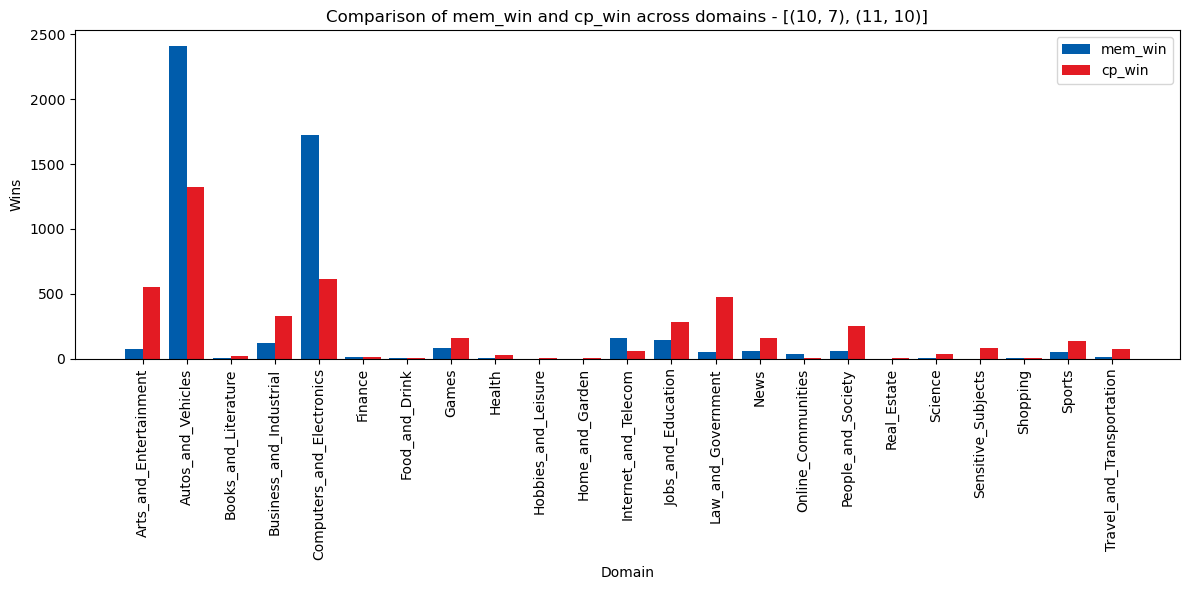

In [62]:
import matplotlib.pyplot as plt

FACTUAL_COLOR = "#005CAB"
COUNTERFACTUAL_COLOR = "#E31B23"

# Plot settings
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(ablation_result["domain"]))

# Plotting bars
plt.bar(x, ablation_result["mem_win"], width=bar_width, label="mem_win", color=FACTUAL_COLOR)
plt.bar([i + bar_width for i in x], ablation_result["cp_win"], width=bar_width, label="cp_win", 
        color=COUNTERFACTUAL_COLOR)

# Adding labels and title
plt.xlabel("Domain")
plt.ylabel("Wins")
plt.title(f"Comparison of mem_win and cp_win across domains - {ablation_layer_heads}")
plt.xticks([i + bar_width / 2 for i in x], ablation_result["domain"], rotation=90)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


### Logit Attribution

In [4]:
from dataset import BaseDataset
from model import ModelFactory
from experiment import LogitAttribution

In [5]:
domains = [row["domain"] for row in domain_dataset]
domains_df = pd.DataFrame({"domain": domains})
domains_df["domain"].value_counts()

domain
Autos_and_Vehicles           3755
Computers_and_Electronics    2406
Arts_and_Entertainment        669
Law_and_Government            544
Jobs_and_Education            484
Business_and_Industrial       473
People_and_Society            345
Games                         267
Internet_and_Telecom          235
News                          234
Sports                        193
Travel_and_Transportation      99
Sensitive_Subjects             86
Science                        46
Online_Communities             42
Finance                        36
Health                         33
Books_and_Literature           27
Food_and_Drink                 12
Real_Estate                     6
Shopping                        4
Hobbies_and_Leisure             3
Home_and_Garden                 1
Name: count, dtype: int64

In [6]:
MODEL_NAME = "gpt2"
DOMAIN = "Sensitive_Subjects"
MODEL_FOLDER = f"{MODEL_NAME}_domain_{DOMAIN}"
EXPERIMENT = "copyVSfactDomain"

In [7]:
logit_attr_model = ModelFactory.create(MODEL_NAME)

 Cuda is not available, switching to cpu 
Loaded pretrained model gpt2 into HookedTransformer


In [8]:
dataset = BaseDataset(
    path= "../data/full_data_sampled_gpt2_with_domains.json",
    model=logit_attr_model,
    experiment="copyVSfact",
    premise="Redefine",
    domain=DOMAIN
)

Filtering for Domain Sensitive_Subjects!


Tokenizing and computing lengths:   0%|          | 0/86 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tokenizing and computing lengths: 100%|██████████| 86/86 [00:00<00:00, 409.17it/s]


In [10]:
logit_attribution = LogitAttribution(
    dataset=dataset,
    model=logit_attr_model,
    batch_size=8,
    experiment="copyVSfact",
)

logit_attr_df = logit_attribution.run()
logit_attr_df

Attributing:   0%|          | 0/11 [00:00<?, ?it/s]

Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now


Attributing:   9%|▉         | 1/11 [00:04<00:48,  4.82s/it]

Tried to stack head results when they weren't cached. Computing head results now


Attributing:  18%|█▊        | 2/11 [00:05<00:22,  2.53s/it]

Tried to stack head results when they weren't cached. Computing head results now


Attributing:  27%|██▋       | 3/11 [00:20<01:05,  8.21s/it]

Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now


Attributing:  36%|███▋      | 4/11 [03:06<08:12, 70.36s/it]

Tried to stack head results when they weren't cached. Computing head results now


Attributing:  45%|████▌     | 5/11 [03:46<05:57, 59.53s/it]

Tried to stack head results when they weren't cached. Computing head results now


Attributing:  55%|█████▍    | 6/11 [04:04<03:47, 45.44s/it]

Tried to stack head results when they weren't cached. Computing head results now


Attributing:  64%|██████▎   | 7/11 [04:06<02:04, 31.05s/it]

Tried to stack head results when they weren't cached. Computing head results now


Attributing:  73%|███████▎  | 8/11 [04:35<01:31, 30.62s/it]

Tried to stack head results when they weren't cached. Computing head results now


Attributing:  82%|████████▏ | 9/11 [05:12<01:04, 32.50s/it]

Tried to stack head results when they weren't cached. Computing head results now


Attributing:  91%|█████████ | 10/11 [06:38<00:49, 49.01s/it]

Tried to stack head results when they weren't cached. Computing head results now


Attributing: 100%|██████████| 11/11 [07:04<00:00, 38.62s/it]


,label,position,mem_mean,cp_mean,diff_mean,mem_std,cp_std,diff_std
0,L0H0,0,0.003548,0.000035,0.003513,0.025830,0.031719,0.041834
1,L0H0,1,0.008058,0.012324,-0.004266,0.022185,0.033281,0.037119
2,L0H0,2,0.012667,0.017614,-0.004946,0.018517,0.034533,0.036036
3,L0H0,3,0.018044,0.017581,0.000462,0.023233,0.028651,0.032691
4,L0H0,4,0.013997,0.010002,0.003995,0.013835,0.024615,0.024437
...,...,...,...,...,...,...,...,...
2422,all_heads,12,0.034782,0.046053,0.000000,0.126442,0.170084,0.000000
2423,all_heads_L10,12,0.092155,0.152299,0.000000,0.205348,0.327262,0.000000
2424,all_heads_L11,12,0.104581,0.127224,0.000000,0.176058,0.221034,0.000000
2425,all_heads_L7,12,0.043601,0.043012,0.000000,0.136977,0.143002,0.000000


In [11]:
def save_dataframe(folder_path, file_name, dataframe):
    print(folder_path)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    dataframe.to_csv(f"{folder_path}/{file_name}.csv", index=False)

In [13]:
save_dataframe(
    f"../results/{EXPERIMENT}/logit_attribution/{MODEL_FOLDER}",
    "logit_attribution_data",
    logit_attr_df,
)

../results/copyVSfactDomain/logit_attribution/gpt2_domain_Sensitive_Subjects


In [215]:
# !python /Users/udit/PycharmProjects/FACT/FACT_project/plotting_scripts/plot_logit_attribution_fig_3_4a.py \
#     {MODEL_NAME} {EXPERIMENT} {MODEL_FOLDER}